# CIFAR10

## Objective

Training models to associate images representing common objects with their class (multiclass classification).

## Context

The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are completely mutually exclusive. There are 50,000 training images and 10,000 test images.

![CIFAR10 images](_images/cifar10.png)

## Instructions and advice

- Follow the main steps of a supervised ML project: data loading and exploring, data preparation, model training and evaluation.
- Use the [PyTorch](https://pytorch.org) library for data loading and model training. If you are new to it, consider following its [official tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).
- Don't forget to setup your environment by importing the necessary Python packages. Several helper functions (see below) have already been defined for you.
- Regarding data preparation, bitmap images should be normalized. You can find an example [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#load-and-normalize-cifar10).
- You may train and evaluate a standard MultiLayer Perceptron, using [this chapter](../ann.ipynb) as a blueprint. Warning: you will have to adapt the inputs of your network to the color images of the CIFAR10 dataset.
- **Bonus**: train a convolutional neural network using [this chapter](../cnn.ipynb) as a blueprint. After training, compare its performance with the MLP results.

## Environment setup

In [1]:
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [3]:
# Utility functions


def plot_loss_acc(history):
    """Plot training loss and accuracy. Takes a Keras-like History object as parameter"""

    loss_values = history["loss"]
    recorded_epochs = range(1, len(loss_values) + 1)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(recorded_epochs, loss_values, ".--", label="Training loss")
    ax1.set_ylabel("Loss")
    ax1.legend()

    acc_values = history["acc"]
    ax2.plot(recorded_epochs, acc_values, ".--", label="Training accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.legend()

    final_loss = loss_values[-1]
    final_acc = acc_values[-1]
    fig.suptitle(
        f"Training loss: {final_loss:.5f}. Training accuracy: {final_acc*100:.2f}%"
    )
    plt.show()


def count_parameters(model, trainable=True):
    """Return the total number of (trainable) parameters for a model"""

    return (
        sum(p.numel() for p in model.parameters() if p.requires_grad)
        if trainable
        else sum(p.numel() for p in model.parameters())
    )


def plot_images(data, labels, model=None):
    """Plot some images with either their true or predicted labels"""

    figure = plt.figure(figsize=(10, 6))
    cols, rows = 8, 4
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)

        # Title is either true or predicted label
        if model is None:
            title = labels[label]
        else:
            # Add a dimension (to match expected shape with batch size) and store image on device memory
            x_img = img[None, :].to(device)
            # Compute predicted label for image
            # Even if the model outputs unormalized logits, argmax gives the predicted label
            pred_label = model(x_img).argmax(dim=1).item()
            title = f"{labels[pred_label]}?"
        plt.title(title)

        plt.axis("off")
        img = img / 2 + 0.5  # unnormalize
        npimg = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
        plt.imshow(npimg, cmap="binary")
    plt.show()

In [4]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")


# PyTorch device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA GPU {torch.cuda.get_device_name(0)} found :)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS GPU found :)")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

Python version: 3.11.1
NumPy version: 1.26.3
PyTorch version: 2.0.1
MPS GPU found :)


## Data loading and exploring

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Dataset contains PIL images of range [0, 1]
        # We transform them to Tensors of normalized range [-1, 1]
        # https://stackoverflow.com/a/65679179
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

cifar_train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transform
)

cifar_test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transform
)

cifar_labels = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


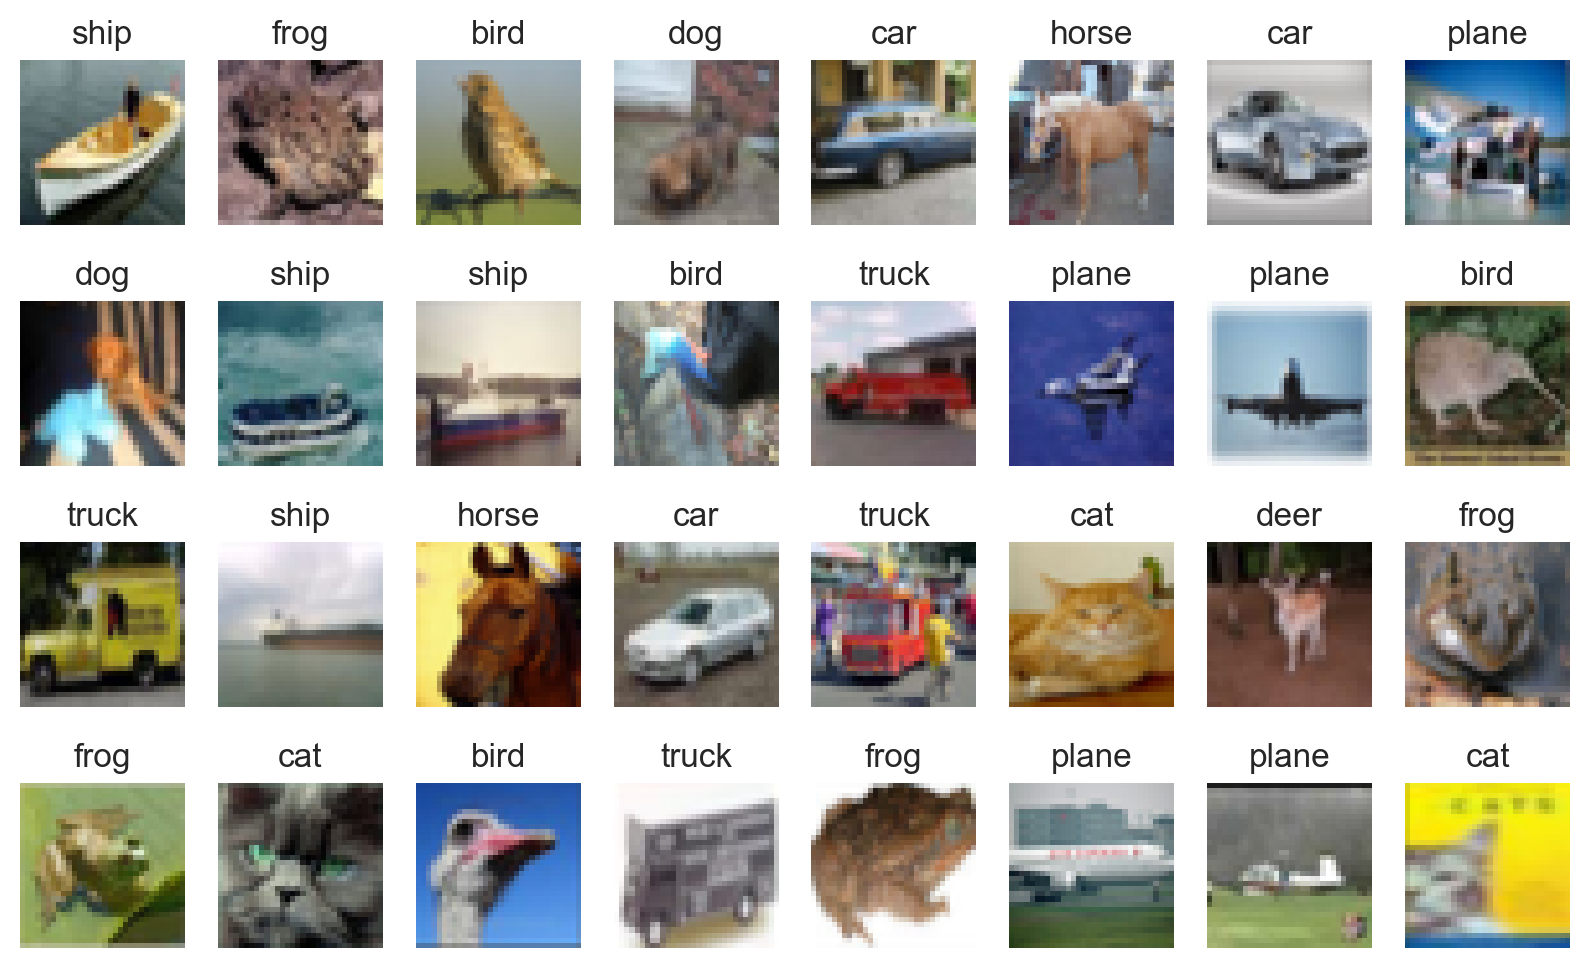

In [6]:
# Plot some of the training images
plot_images(cifar_train_data, cifar_labels)

## Hyperparameters

In [7]:
# Hyperparameters
learning_rate = 1e-3
n_epochs = 10
batch_size = 64

## Data preparation

In [8]:
cifar_train_dataloader = DataLoader(cifar_train_data, batch_size=batch_size)
cifar_test_dataloader = DataLoader(cifar_test_data, batch_size=batch_size)

## Training a MLP

### Model definition

In [9]:
class NeuralNetwork(nn.Module):
    """Neural network for CIFAR images classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (3, 32, 32) into a vector of shape (3*32*32,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 784 inputs
            nn.Linear(in_features=3 * 32 * 32, out_features=64),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            # Output layer
            nn.Linear(in_features=64, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [10]:
cifar_mlp = NeuralNetwork().to(device)
print(cifar_mlp)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(cifar_mlp)}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Number of trainable parameters: 201482


### Model training

In [11]:
def epoch_loop(dataloader, model, loss_fn, optimizer):
    """Training algorithm for one epoch"""

    total_loss = 0
    n_correct = 0

    for x_batch, y_batch in dataloader:
        # Load data and targets on device memory
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        # Backward pass: backprop and GD step
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            total_loss += loss.item()
            n_correct += (model(x_batch).argmax(dim=1) == y_batch).float().sum().item()

    return total_loss, n_correct

In [12]:
def fit(dataloader, model, loss_fn, optimizer, epochs):
    """Main training code"""

    history = {"loss": [], "acc": []}
    n_samples = len(dataloader.dataset)
    n_batches = len(dataloader)

    print(f"Training started! {n_samples} samples. {n_batches} batches per epoch")

    for epoch in range(epochs):
        total_loss, n_correct = epoch_loop(dataloader, model, loss_fn, optimizer)

        # Compute epoch metrics
        epoch_loss = total_loss / n_batches
        epoch_acc = n_correct / n_samples

        print(
            f"Epoch [{(epoch + 1):3}/{epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

        # Record epoch metrics for later plotting
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

    print(f"Training complete! Total gradient descent steps: {epochs * n_batches}")

    return history

In [13]:
cifar_mlp_history = fit(
    dataloader=cifar_train_dataloader,
    model=cifar_mlp,
    # Standard loss for multiclass classification
    loss_fn=nn.CrossEntropyLoss(),
    # Adam optimizer for GD
    optimizer=optim.Adam(cifar_mlp.parameters(), lr=learning_rate),
    epochs=n_epochs,
)

Training started! 50000 samples. 782 batches per epoch
Epoch [  1/ 10]. Mean loss: 1.67096. Accuracy: 42.37%
Epoch [  2/ 10]. Mean loss: 1.48440. Accuracy: 49.04%
Epoch [  3/ 10]. Mean loss: 1.39945. Accuracy: 52.23%
Epoch [  4/ 10]. Mean loss: 1.33789. Accuracy: 54.53%
Epoch [  5/ 10]. Mean loss: 1.28894. Accuracy: 56.45%
Epoch [  6/ 10]. Mean loss: 1.24686. Accuracy: 57.90%
Epoch [  7/ 10]. Mean loss: 1.21420. Accuracy: 59.08%
Epoch [  8/ 10]. Mean loss: 1.18274. Accuracy: 60.28%
Epoch [  9/ 10]. Mean loss: 1.15456. Accuracy: 61.28%
Epoch [ 10/ 10]. Mean loss: 1.13053. Accuracy: 62.03%
Training complete! Total gradient descent steps: 7820


### Training results

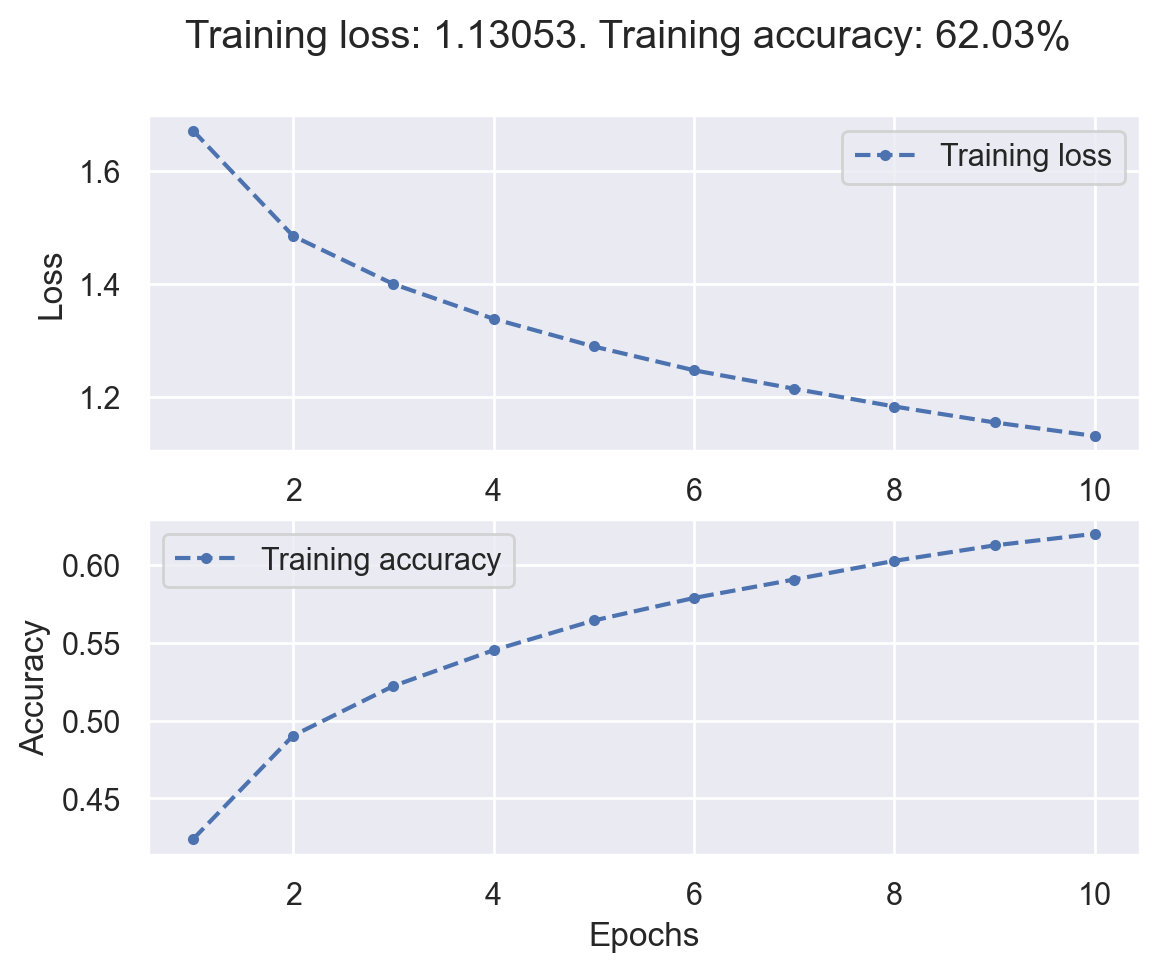

In [14]:
# Plot training history
plot_loss_acc(cifar_mlp_history)

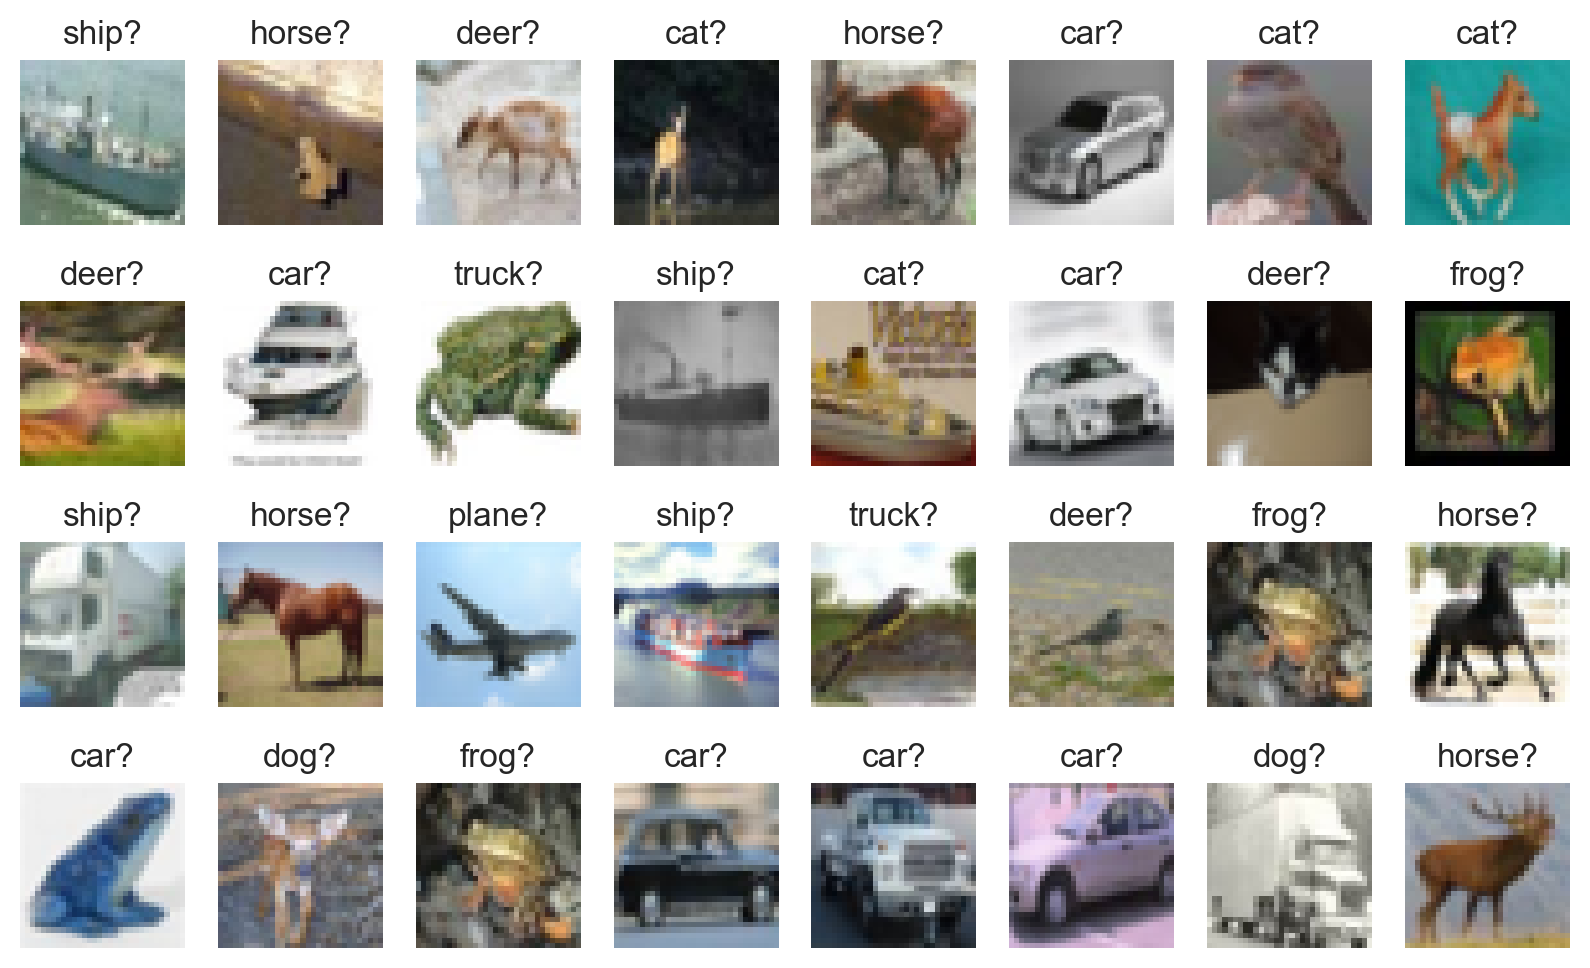

In [15]:
# Show model predictions on some test images
plot_images(cifar_test_data, cifar_labels, cifar_mlp)

### Results interpretation

Although training smoothly, the MLP model incorrectly classifies more than 1/3 of the training data. Its architecture is too limited for this non-trivial task.

## Training a convnet

### Model definition

In [16]:
class Convnet(nn.Module):
    """Convnet for CIFAR image classification"""

    def __init__(self):
        super().__init__()

        # Define a sequential stack
        self.layer_stack = nn.Sequential(
            # Feature extraction part, with convolutional and pooling layers
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Classification part, with fully connected layers
            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [17]:
cifar_convnet = Convnet().to(device)
print(cifar_convnet)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(cifar_convnet)}")

Convnet(
  (layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
Number of trainable parameters: 315722


### Model training

In [18]:
cifar_convnet_history = fit(
    dataloader=cifar_train_dataloader,
    model=cifar_convnet,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(cifar_convnet.parameters(), lr=learning_rate),
    epochs=n_epochs,
)

Training started! 50000 samples. 782 batches per epoch
Epoch [  1/ 10]. Mean loss: 1.43523. Accuracy: 50.20%
Epoch [  2/ 10]. Mean loss: 1.08590. Accuracy: 63.53%
Epoch [  3/ 10]. Mean loss: 0.94643. Accuracy: 68.52%
Epoch [  4/ 10]. Mean loss: 0.84719. Accuracy: 72.17%
Epoch [  5/ 10]. Mean loss: 0.76482. Accuracy: 75.33%
Epoch [  6/ 10]. Mean loss: 0.69466. Accuracy: 77.74%
Epoch [  7/ 10]. Mean loss: 0.63077. Accuracy: 80.18%
Epoch [  8/ 10]. Mean loss: 0.57295. Accuracy: 82.40%
Epoch [  9/ 10]. Mean loss: 0.52190. Accuracy: 84.37%
Epoch [ 10/ 10]. Mean loss: 0.47863. Accuracy: 86.18%
Training complete! Total gradient descent steps: 7820


### Training results

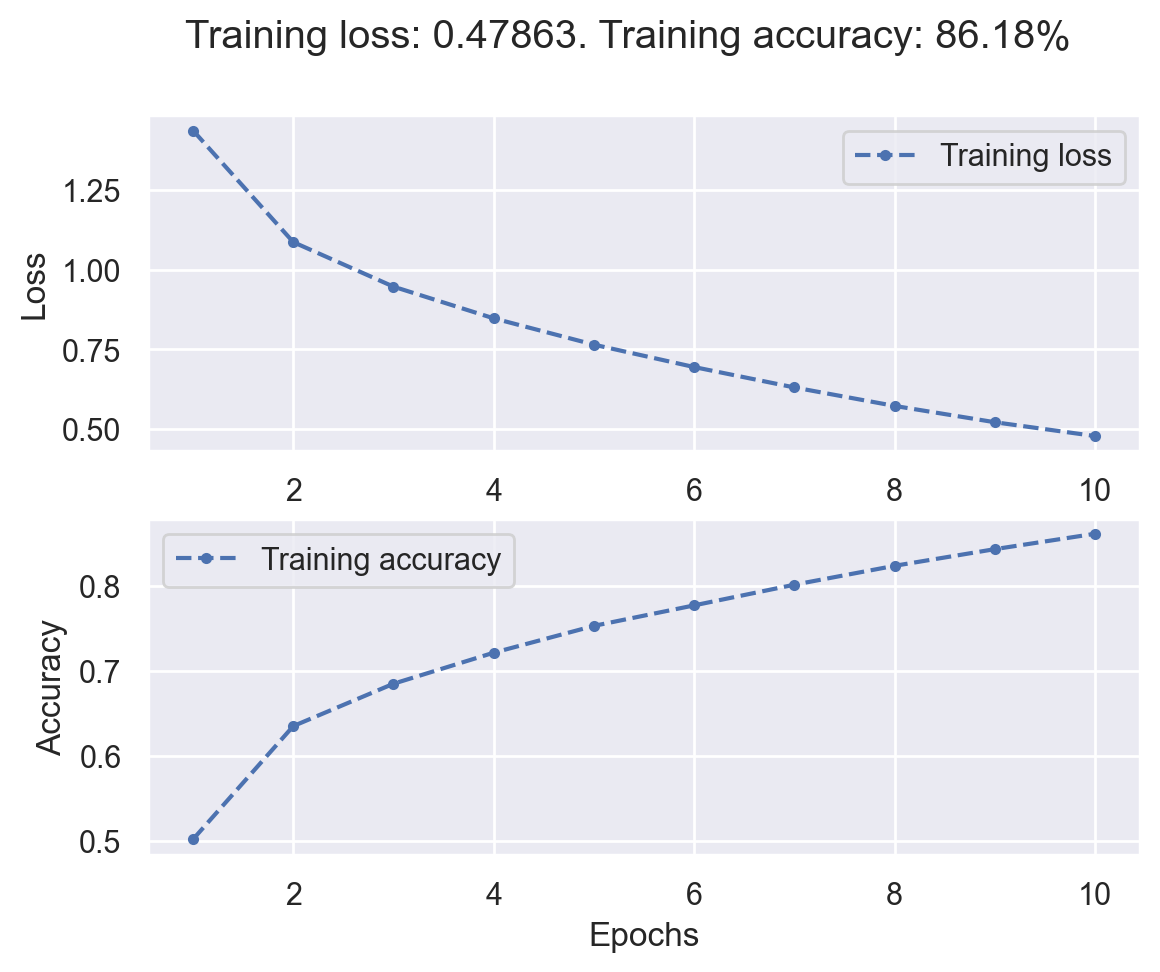

In [19]:
# Plot training history
plot_loss_acc(cifar_convnet_history)

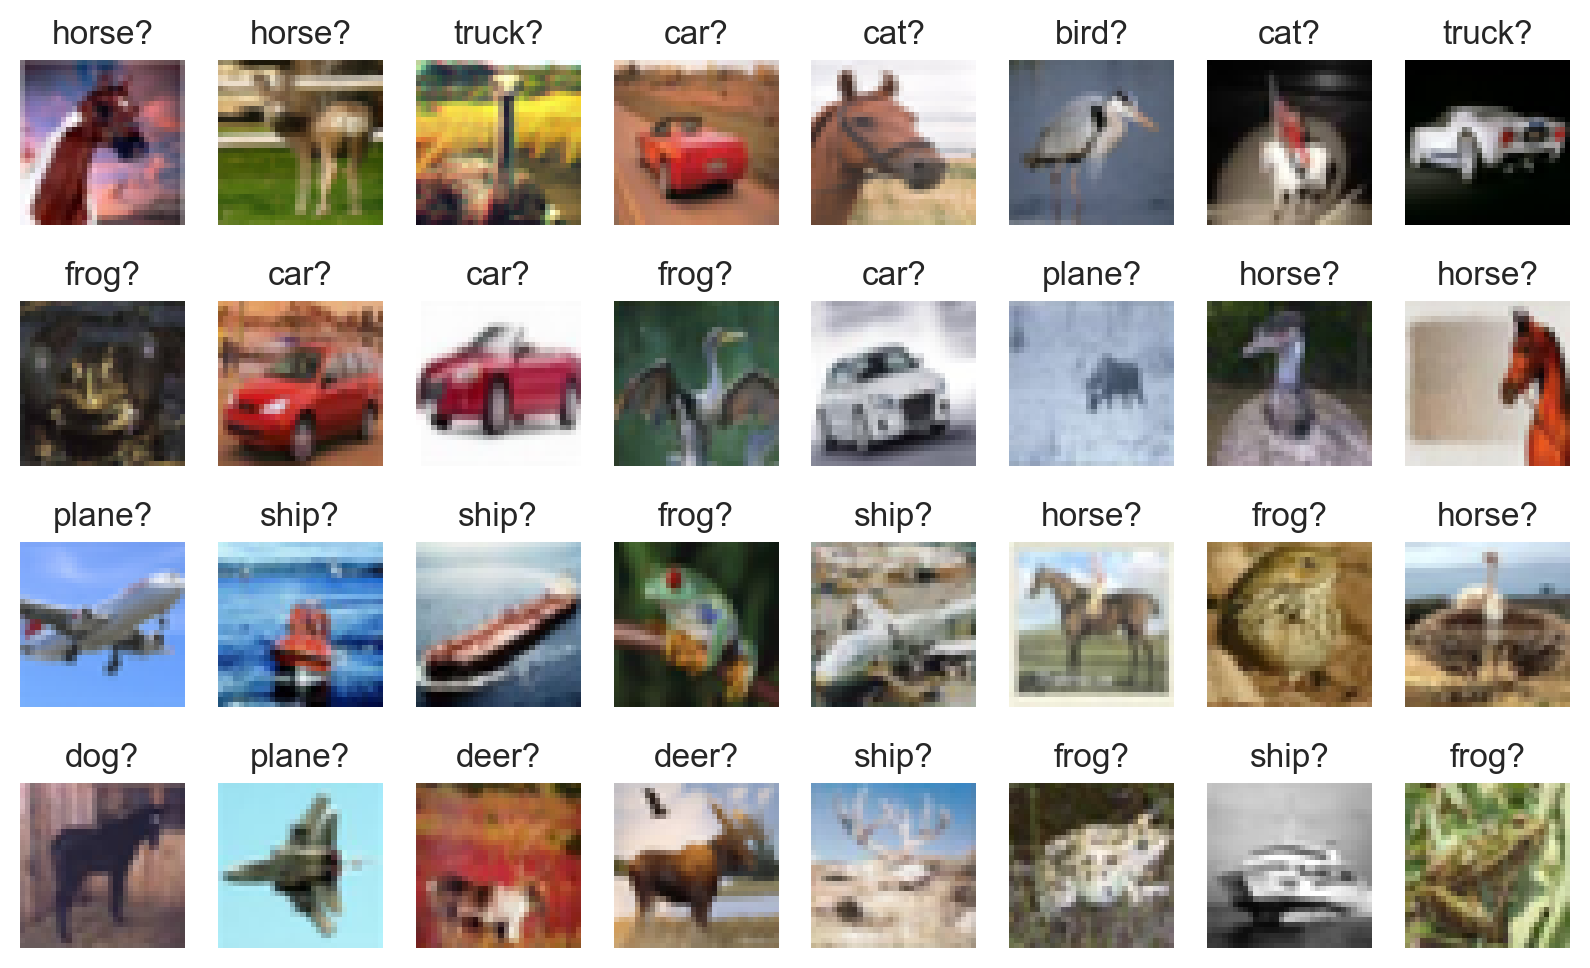

In [20]:
# Show model predictions on some test images
plot_images(cifar_test_data, cifar_labels, cifar_convnet)

### Results interpretation

The convnet is much better than the MLP at classifying CIFAR10 images, which is not surprising given that its architecture was invented for this kind of tasks.

Results could probably be even better with a longer training time.